## Directly Shared Domains by Politician

**Purpose**: identify which media outlets resonate directly with congressional Republicans over the 2016-2020 period. Politician-level analysis.

In [1]:
import pandas as pd
import os
import datetime

%matplotlib inline
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format

In [2]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '03-direct-shared-domains-by-politican', logger_type='main')

In [3]:
# for importing df_urls
urls_dir = os.path.join("..", "..", "data", "03-analysis")
figs_dir = os.path.join("..", "..", "figures", "direct")

### 1. Import directly shared URLs

In [4]:
# import the file prepared by 02-direct-shared-domains.ipynb
# only includes 
df_urls = pd.read_pickle(os.path.join(urls_dir, "direct_shared_domains.pkl"))

In [5]:
print(f"{len(df_urls)} URLs which are from recognized outlets (including non-right-wing media).")

36019 URLs which are from recognized outlets (including non-right-wing media).


In [6]:
df_urls.columns

Index(['url_id', 'created_at', 'created_at_year', 'username',
       'standardized_url', 'url_netloc', 'urlexpander_error', 'outlet',
       'outlet_std', 'is_selected_outlet', 'pew_libdem', 'pew_consrep',
       'pew_libdem_consrep_diff', 'ideo_category', 'ideo_subcategory',
       'ideo_left2right'],
      dtype='object')

In [7]:
df_urls.head()

url_id          created_at created_at_year         username  \
0  1016809976789159937_0 2018-07-10 22:22:44      2018-01-01       KenCalvert   
1   706936239220330498_0 2016-03-07 20:15:08      2016-01-01       KenCalvert   
2   735190770035138560_0 2016-05-24 19:28:33      2016-01-01      RepComstock   
3   971799132707926016_0 2018-03-08 17:25:43      2018-01-01         RepByrne   
4  1204042988285919233_0 2019-12-09 14:19:53      2019-01-01  RepChrisStewart   

                                    standardized_url              url_netloc  \
0  www.washingtonexaminer.com/policy/economy/hire...  washingtonexaminer.com   
1  www.washingtonexaminer.com/how-a-new-bill-to-f...  washingtonexaminer.com   
2  www.washingtonexaminer.com/lawmaker-let-privat...  washingtonexaminer.com   
3  www.washingtonexaminer.com/how-to-end-governme...  washingtonexaminer.com   
4  www.washingtonexaminer.com/opinion/utah-republ...  washingtonexaminer.com   

  urlexpander_error               outlet          outlet_std  \
0          no error  Washington Examiner  washingtonexaminer   
1          no error  Washington Examiner  washingtonexaminer   
2          no error  Washington Examiner  washingtonexaminer   
3          no error  Washington Examiner  washingtonexaminer   
4          no error  Washington Examiner  washingtonexaminer   

   is_selected_outlet  pew_libdem  pew_consrep  pew_libdem_consrep_diff  \
0                True        14.0         44.0                    -29.0   
1                True        14.0         44.0                    -29.0   
2                True        14.0         44.0                    -29.0   
3                True        14.0         44.0                    -29.0   
4                True        14.0         44.0                    -29.0   

  ideo_category   ideo_subcategory  ideo_left2right  
0         right  established right             24.0  
1         right  established right             24.0  
2         right  established right             24.0  
3         right  established right             24.0  
4         right  established right             24.0

In [8]:
# some scraping attempts of (re-)tweeted URLs returned errors.
# while the text content was not retrieved, we can still use the URL domain which was returned to identify the associated outlet.
df_urls.groupby("urlexpander_error").size()

urlexpander_error
CLIENT_ERROR              488
CONNECTIONPOOL_ERROR     1905
no error                33626
dtype: int64

### 2. analyze (re-)tweets per politician by year and ideo_subcategory

In [9]:
df_ps = df_urls.groupby(['username', 'created_at_year', 'ideo_subcategory'])['outlet']\
       .count().sort_values(ascending=False)\
       .to_frame('count_by_year_ideo').query('count_by_year_ideo >= 0')

df_ps['total_across_years'] = df_ps.groupby(level=0).transform(lambda x: x.sum())
df_ps['count_by_year'] = df_ps.groupby(['username', 'created_at_year'])['count_by_year_ideo'].transform(lambda x: x.sum())
df_ps = df_ps.reset_index(drop=False)
df_ps['percent_by_year'] = df_ps['count_by_year_ideo'] / df_ps['count_by_year']*100
df_ps['label'] =  df_ps.agg(lambda x: f"{round(x['percent_by_year'], 1)}% ({int(x['count_by_year_ideo'])})", axis=1)
df_ps

username created_at_year   ideo_subcategory  count_by_year_ideo  \
0        JohnCornyn      2016-01-01               left                 474   
1        JohnCornyn      2018-01-01               left                 424   
2        JohnCornyn      2017-01-01               left                 395   
3        JohnCornyn      2020-01-01              mixed                 349   
4        JohnCornyn      2016-01-01  established right                 305   
...             ...             ...                ...                 ...   
3250    RepGrothman      2016-01-01  established right                   1   
3251  RepGregSteube      2019-01-01               left                   1   
3252     SenMikeLee      2020-01-01  alternative right                   1   
3253   RepGregPence      2020-01-01              mixed                   1   
3254  AnderCrenshaw      2016-01-01               left                   1   

      total_across_years  count_by_year  percent_by_year        label  
0                   3917           1045        45.358852  45.4% (474)  
1                   3917            776        54.639175  54.6% (424)  
2                   3917            732        53.961749  54.0% (395)  
3                   3917            735        47.482993  47.5% (349)  
4                   3917           1045        29.186603  29.2% (305)  
...                  ...            ...              ...          ...  
3250                  61              3        33.333333    33.3% (1)  
3251                  68              6        16.666667    16.7% (1)  
3252                  99             20         5.000000     5.0% (1)  
3253                  22              5        20.000000    20.0% (1)  
3254                   1              1       100.000000   100.0% (1)  

[3255 rows x 8 columns]

In [10]:
# # https://plotnine.readthedocs.io/en/stable/tutorials/miscellaneous-order-plot-series.html#Bar-plot-of-manufacturer---Ordered-by-count-(Categorical)
# aim: usernames ranked by total across years
# this code doesn't work yet as df_ps does not contain unique values by 'username' (username is repeated across years); how to apply the sort order in this case?

# usernames_ranked = df_ps.groupby('username').first()['total_across_years'].sort_values(ascending=False)
# usernames_cat = pd.Categorical(df_ps['username'], categories=usernames_ranked)
# df_ps = df_ps.assign(usernames_cat = usernames_cat)
# df_ps

In [11]:
def plot_user(username):
    # https://stackoverflow.com/a/40724329
    plot = (p9.ggplot(data=df_ps.query(f'username == "{username}"'),
                        mapping=p9.aes(x='created_at_year', y='count_by_year_ideo'))
                     + p9.geom_col(p9.aes(fill='ideo_subcategory'), stat='identity', alpha = 0.5)
                     + p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey'])
                     + p9.geom_text(
                         p9.aes(label='label', group='ideo_subcategory'),
                         position = p9.position_stack(vjust = .5),
                         size=8
                     )
                     + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='1 years')
                     + p9.scale_y_continuous(expand=(0, 20, 0, 100)) # to prevent Fox label from getting cutoff
                     + p9.facet_wrap("username", labeller='label_value', ncol=5)
                     + p9.theme_light()
                     + p9.labs(title=f"(Re-)Tweets by Politician: {username}",
                            fill='',
                            x='year',
                            y='count of (re-)tweets')
                    )
    return plot

In [12]:
# selected politicians: tweeted on average more than 2x per week in at least one year
# GOPLeader = Kevin McCarthy
selected_usernames = list(df_ps.query("count_by_year > 104")['username'].unique())
selected_usernames.append("GOPLeader")
selected_usernames

['JohnCornyn',
 'RepAndyBiggsAZ',
 'jasoninthehouse',
 'SenTedCruz',
 'RepBrianBabin',
 'SenJohnMcCain',
 'RepJimBanks',
 'senorrinhatch',
 'MarshaBlackburn',
 'SpeakerRyan',
 'RandPaul',
 'RepGosar',
 'RepMattGaetz',
 'SteveScalise',
 'replouiegohmert',
 'SenRickScott',
 'PeterRoskam',
 'CongHuelskamp',
 'RepDougCollins',
 'Jim_Jordan',
 'RepDLesko',
 'RepByrne',
 'SenTomCotton',
 'USRepLong',
 'RepChipRoy',
 'RepKinzinger',
 'farenthold',
 'DavidVitter',
 'RepMarkWalker',
 'RepMarkGreen',
 'senrobportman',
 'SenHawleyPress',
 'RepKenBuck',
 'cathymcmorris',
 'SenatorBraun',
 'SenatorKirk',
 'GOPLeader']

In [13]:
len(selected_usernames)

37

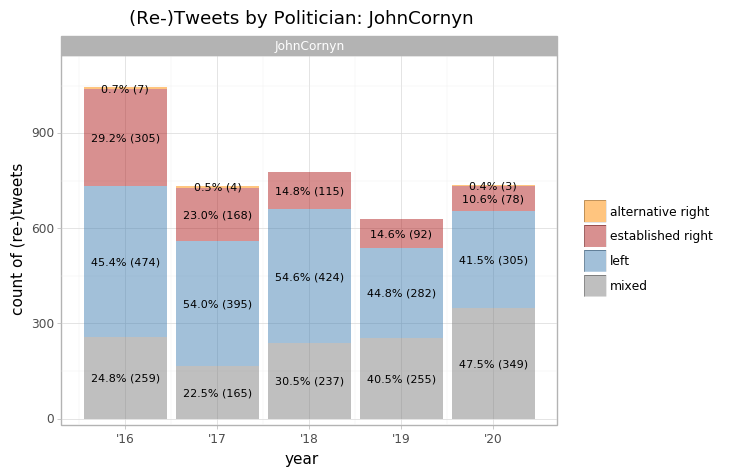

<ggplot: (8787936496595)>

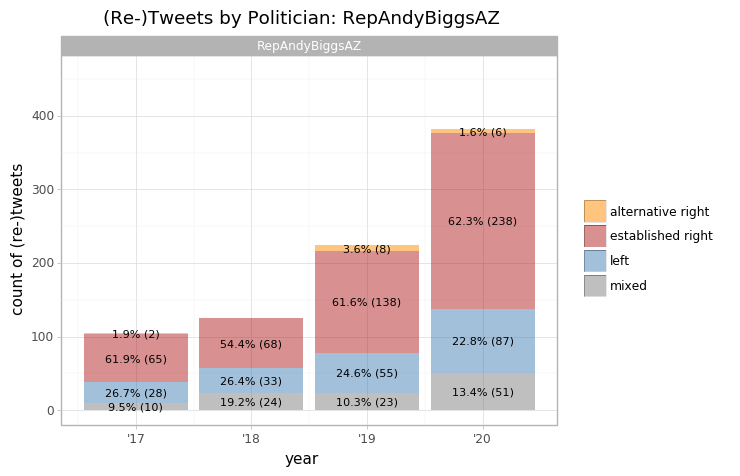

<ggplot: (8787936438935)>

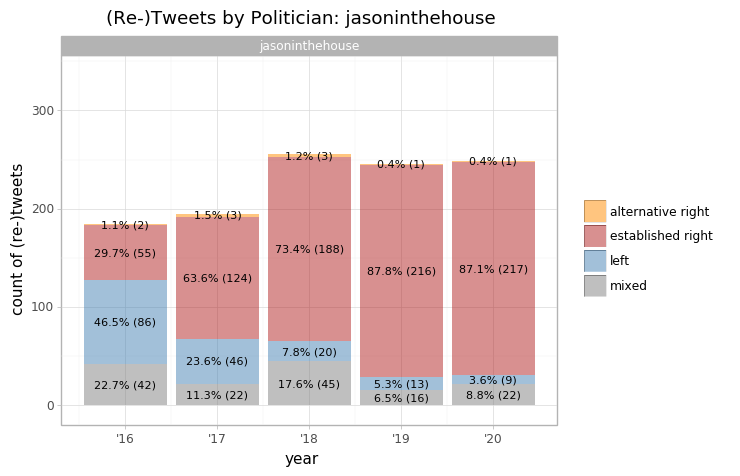

<ggplot: (8787936378043)>

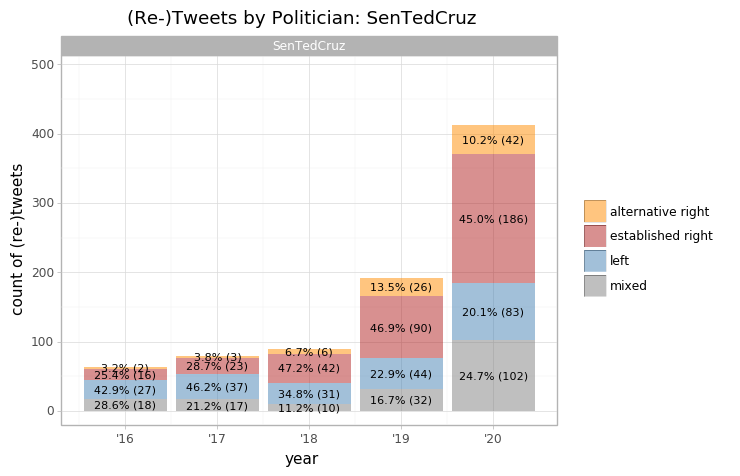

<ggplot: (8787936412212)>

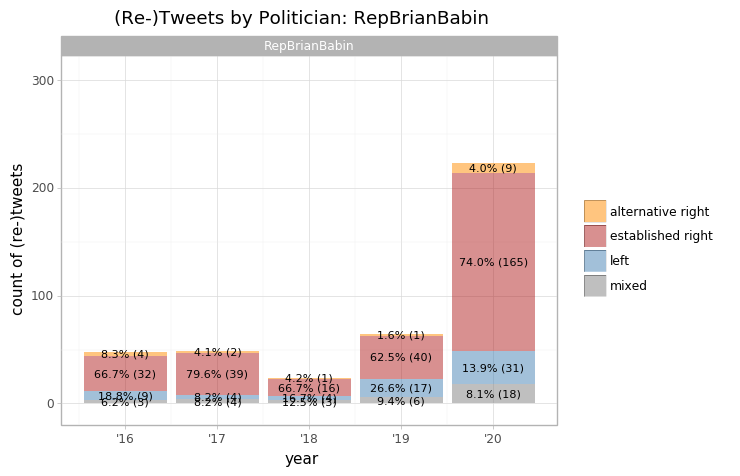

<ggplot: (8787936350284)>

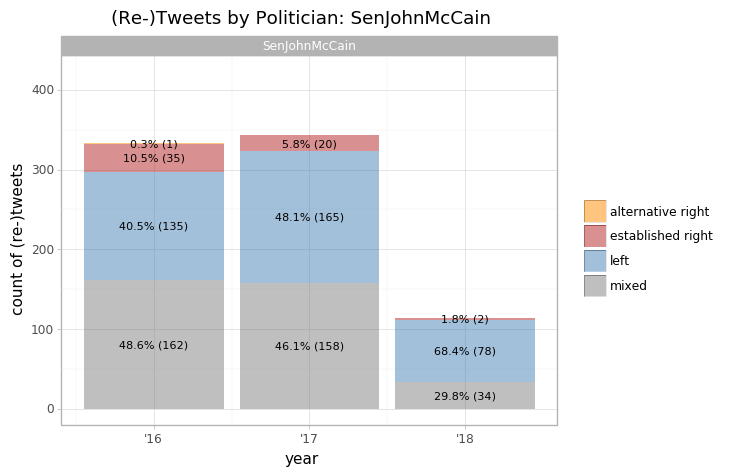

<ggplot: (8787936513208)>

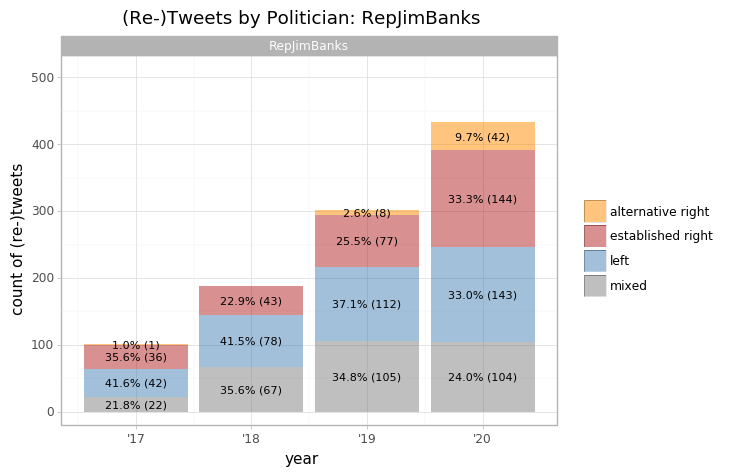

<ggplot: (8787936387446)>

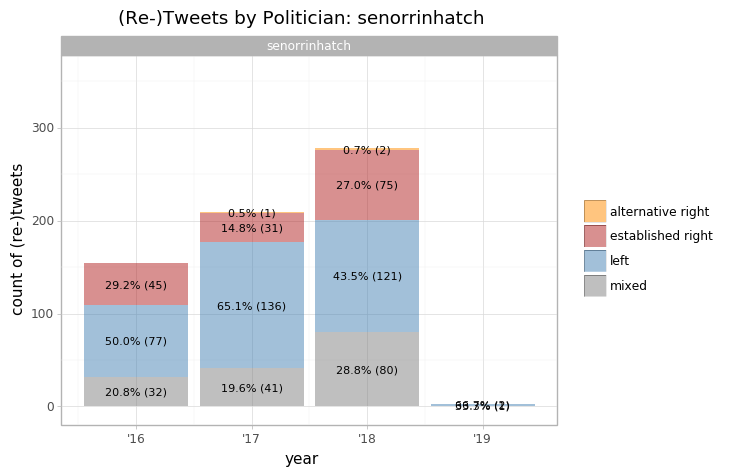

<ggplot: (8787936484922)>

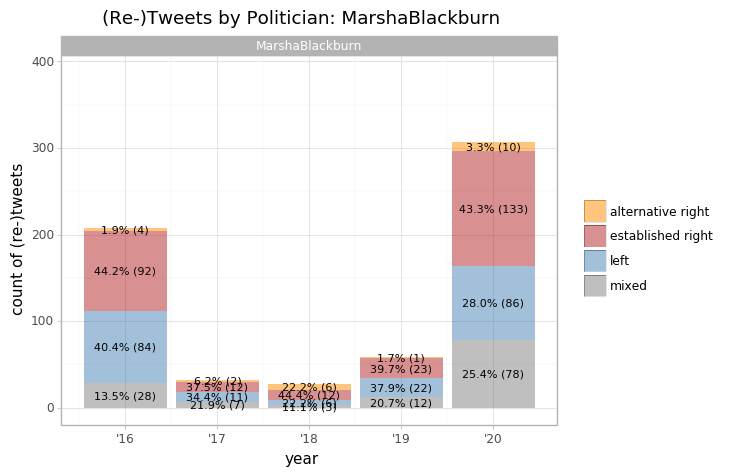

<ggplot: (8787936116468)>

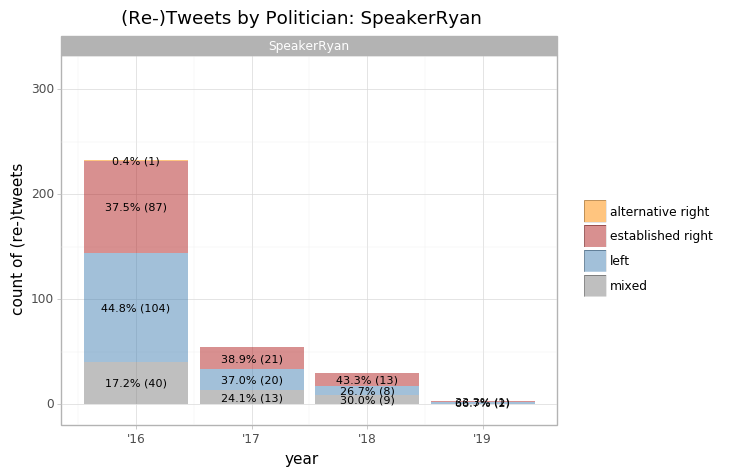

<ggplot: (8787936055155)>

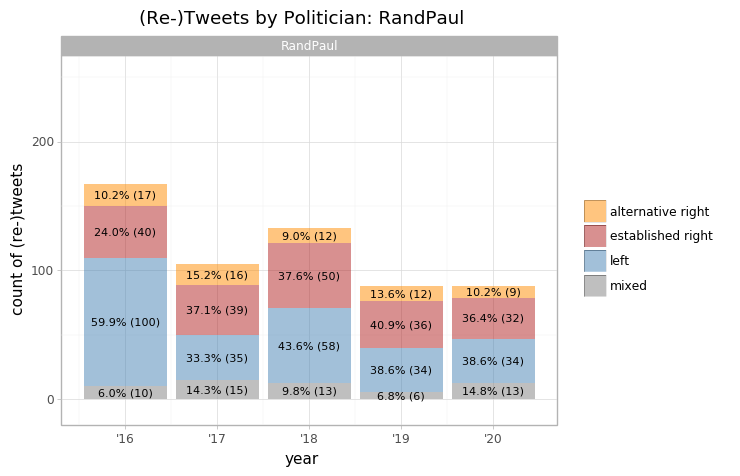

<ggplot: (8787935955935)>

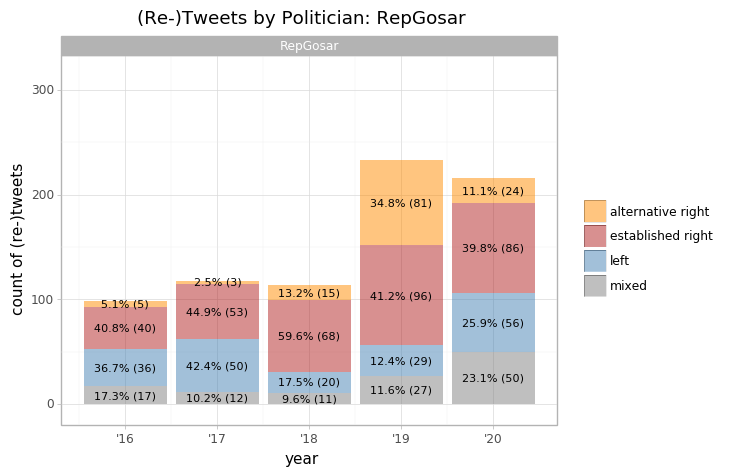

<ggplot: (8787936062016)>

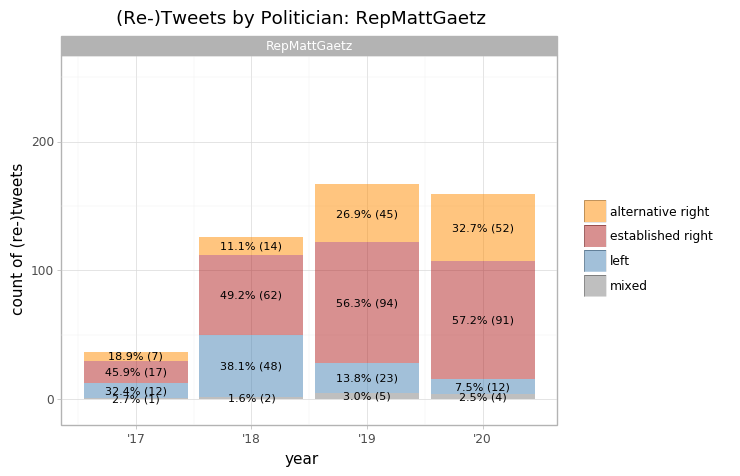

<ggplot: (8787935991287)>

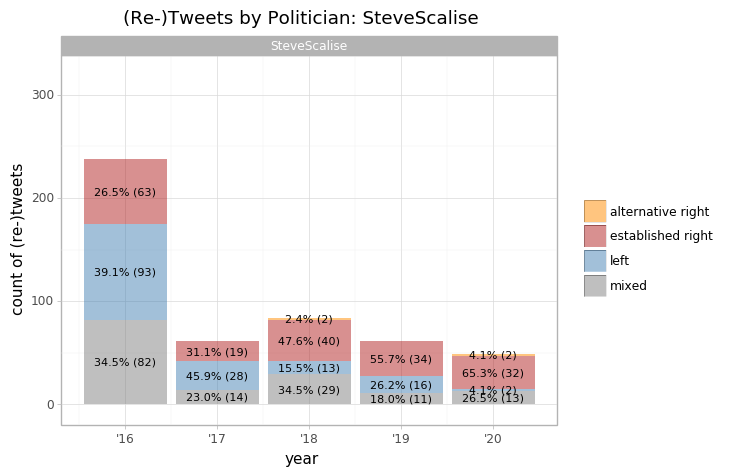

<ggplot: (8787936084161)>

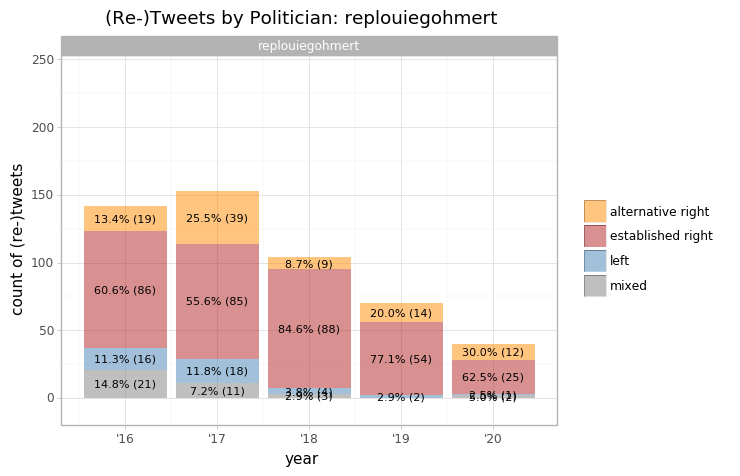

<ggplot: (8787935913807)>

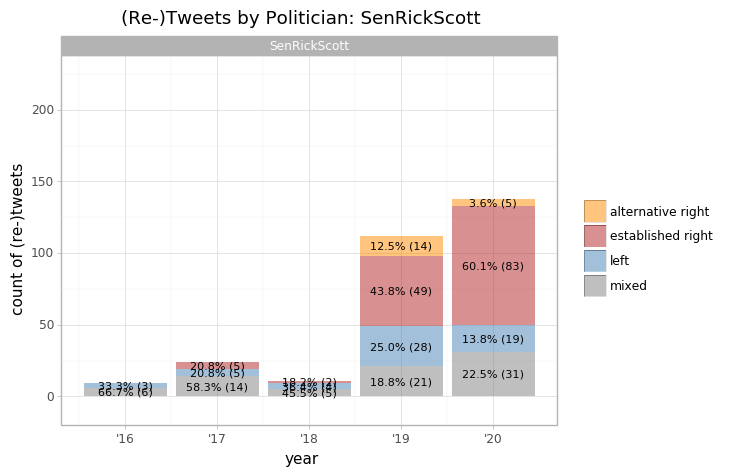

<ggplot: (8787936457611)>

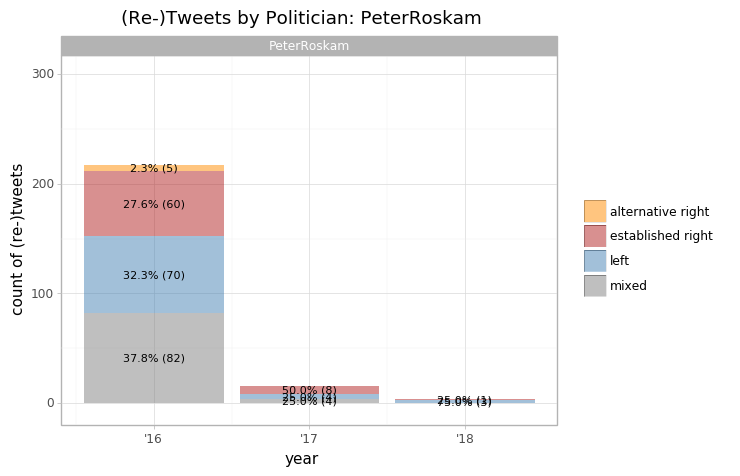

<ggplot: (8787936169704)>

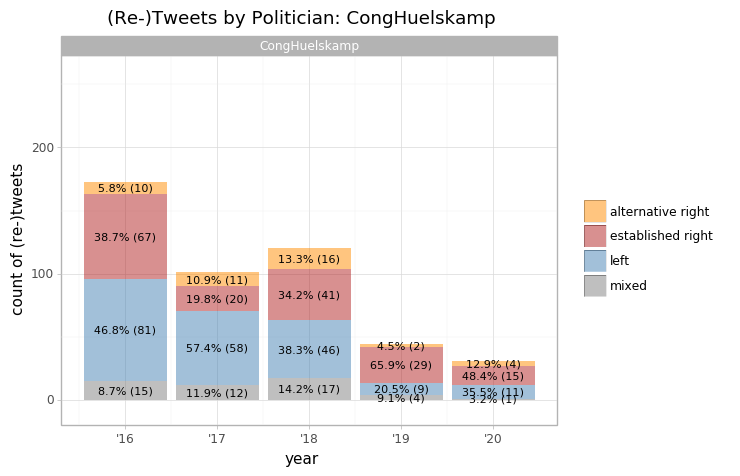

<ggplot: (8787936475115)>

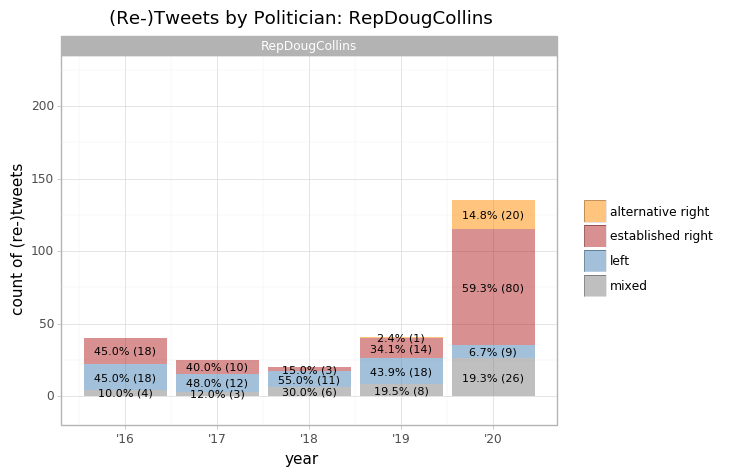

<ggplot: (8787935937268)>

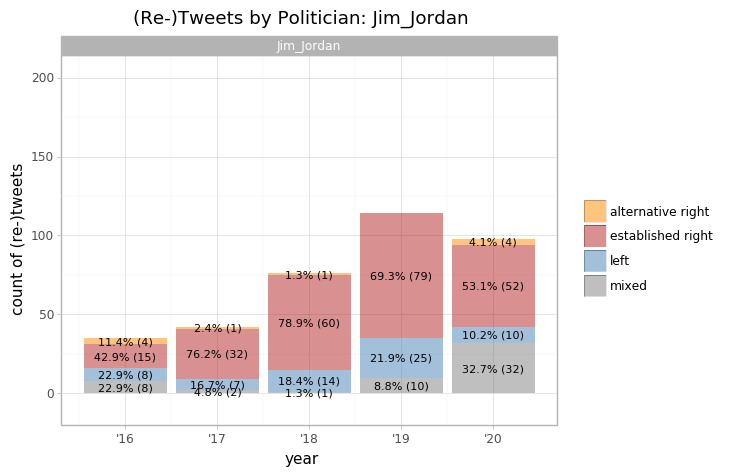

<ggplot: (8787935827014)>

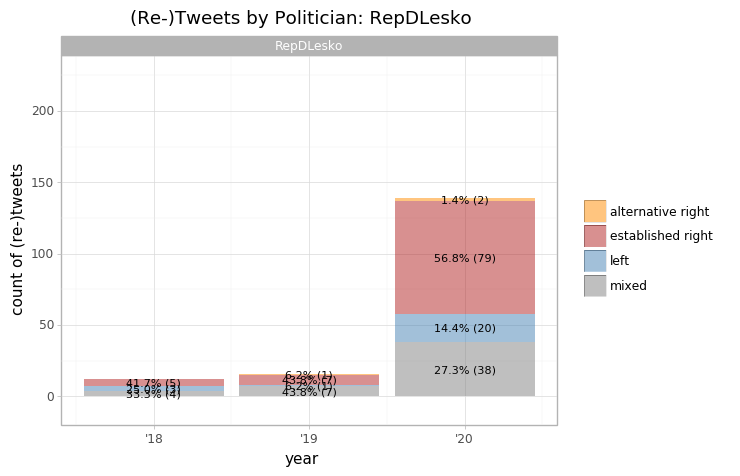

<ggplot: (8787935733962)>

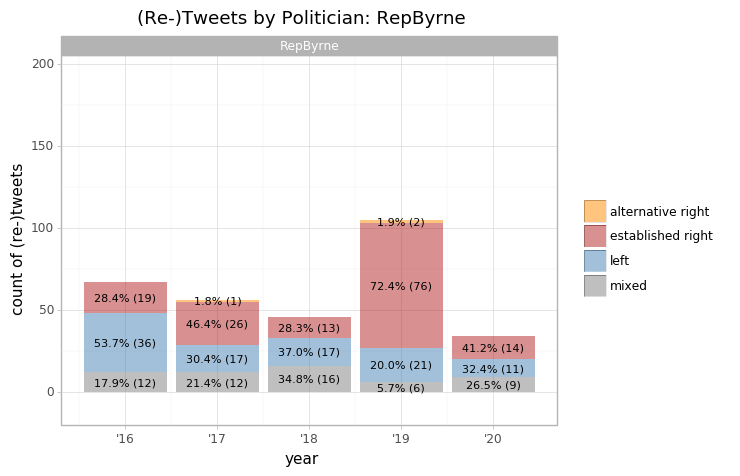

<ggplot: (8787936484837)>

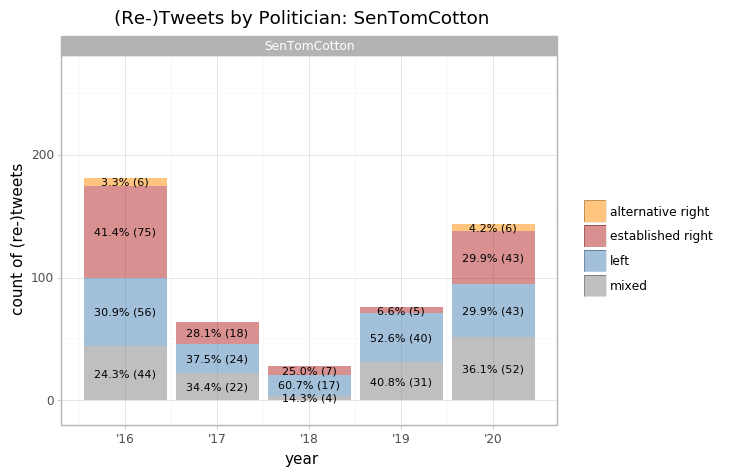

<ggplot: (8787935686663)>

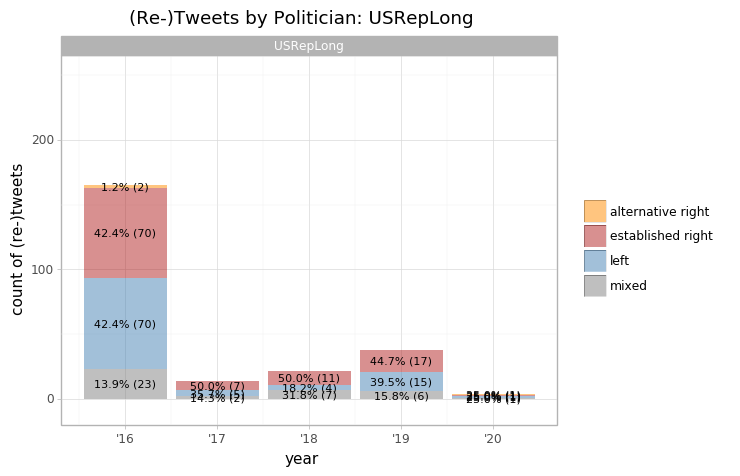

<ggplot: (8787935637315)>

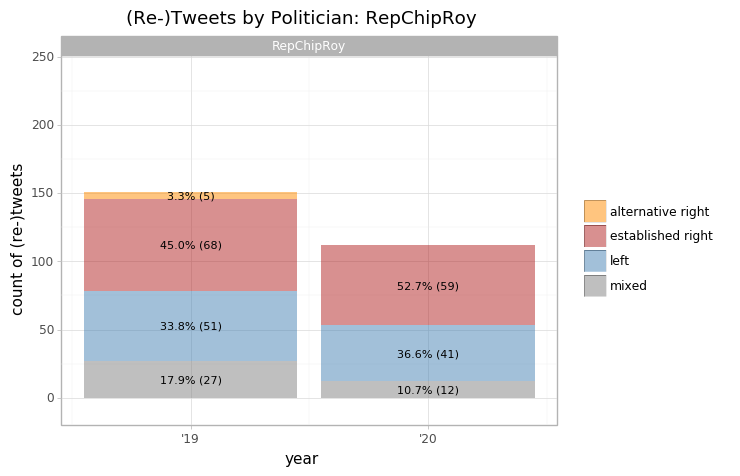

<ggplot: (8788124305053)>

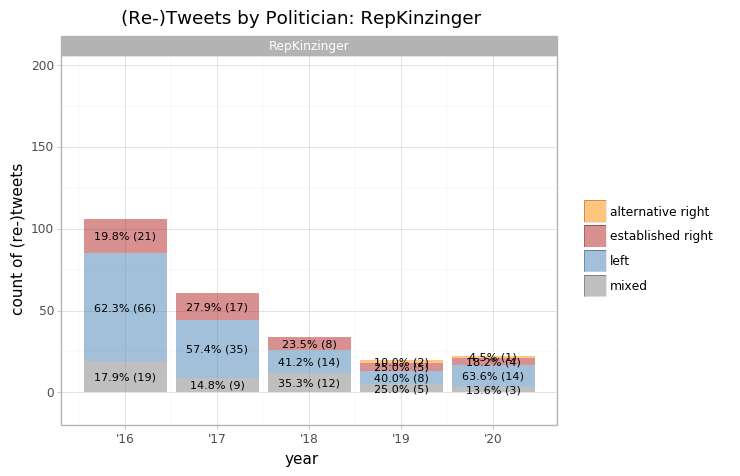

<ggplot: (8787935802441)>

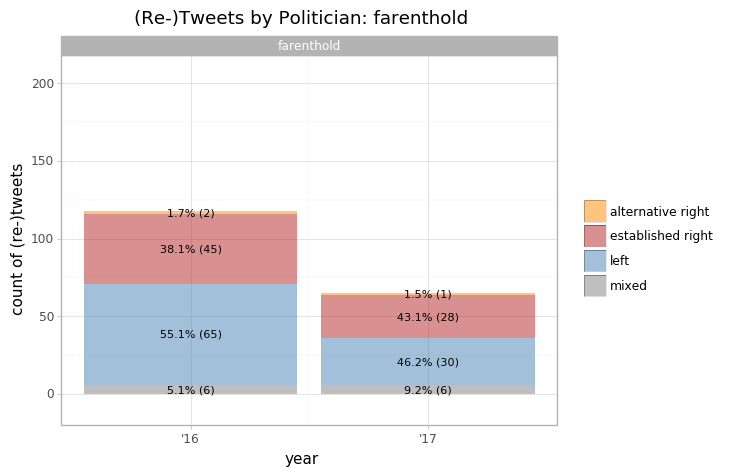

<ggplot: (8787936488051)>

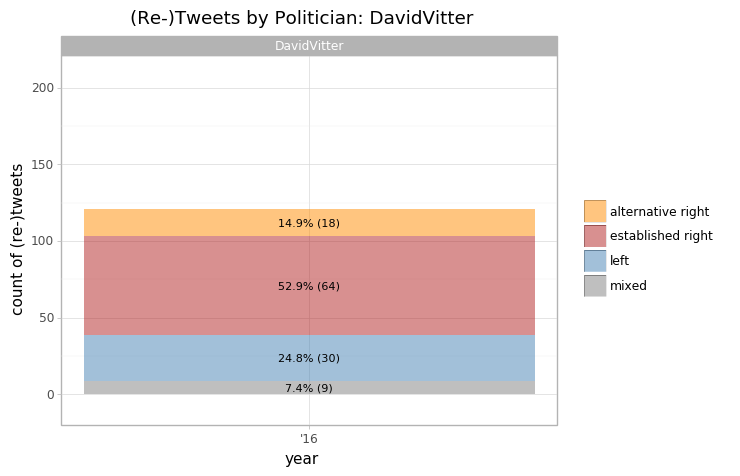

<ggplot: (8787936004190)>

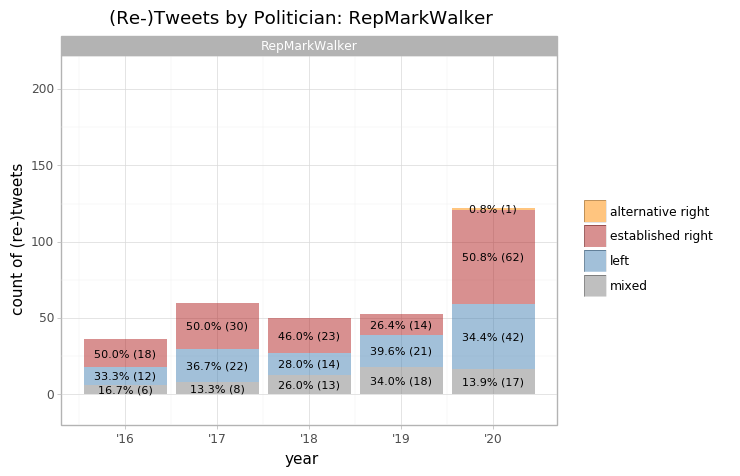

<ggplot: (8787936133316)>

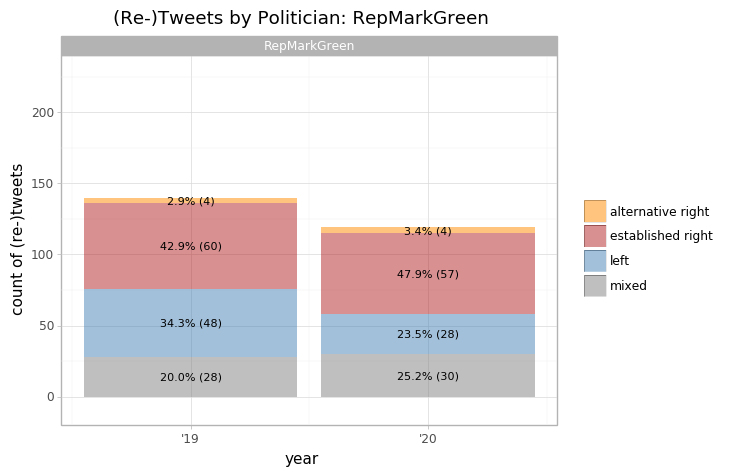

<ggplot: (8787936097097)>

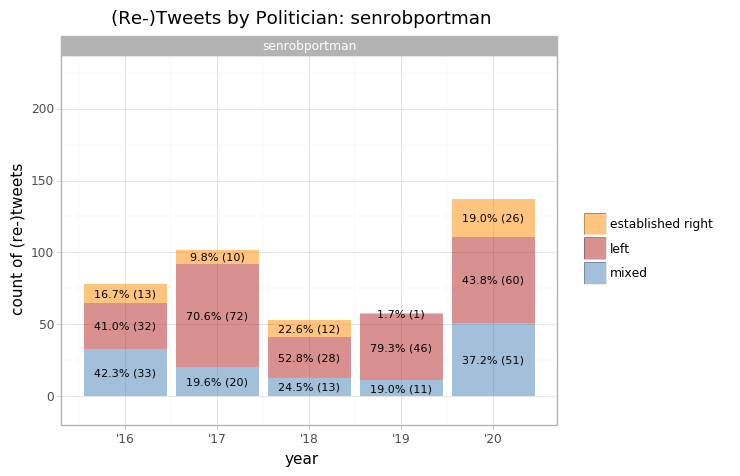

<ggplot: (8787936479973)>

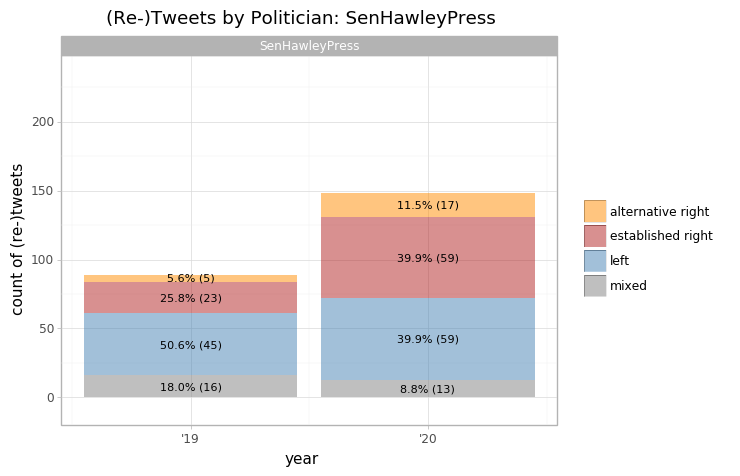

<ggplot: (8787935525626)>

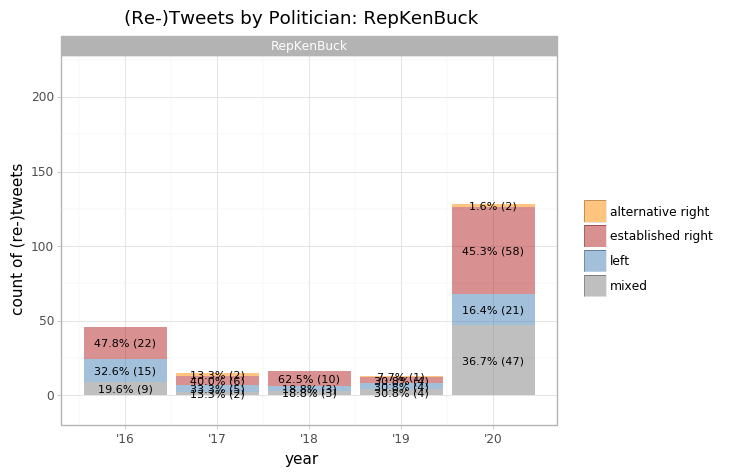

<ggplot: (8787935891207)>

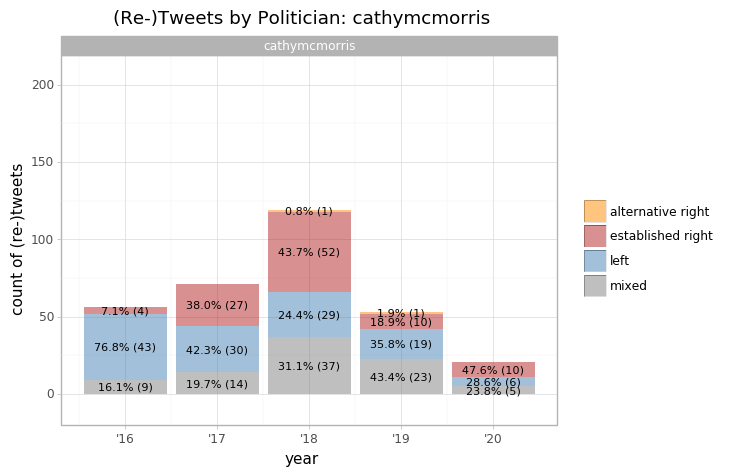

<ggplot: (8787935908880)>

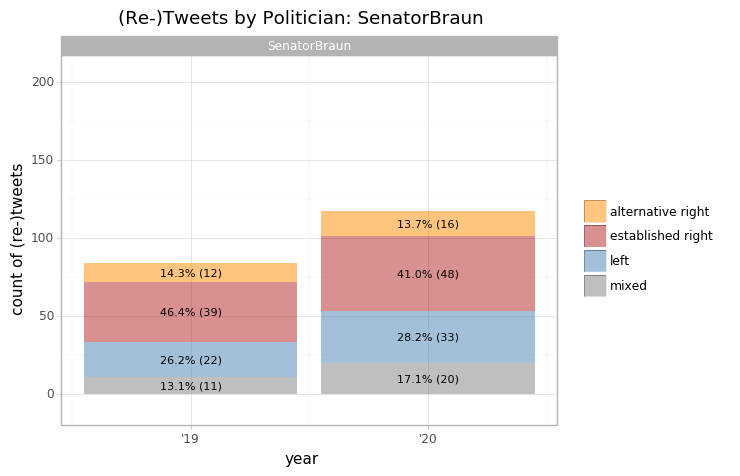

<ggplot: (8787935485501)>

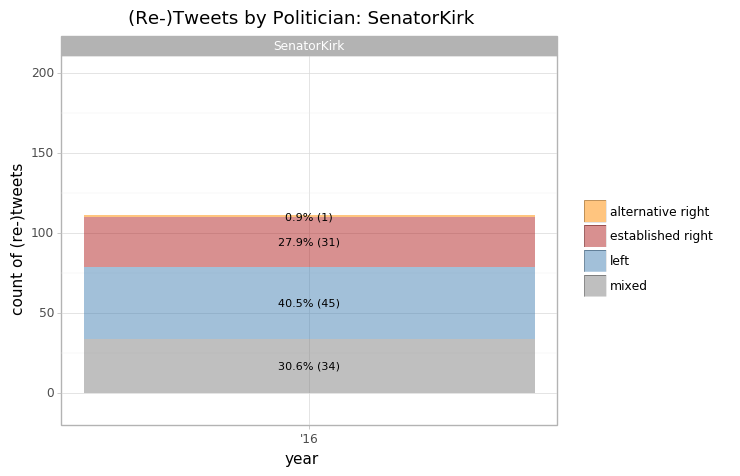

<ggplot: (8787936071584)>

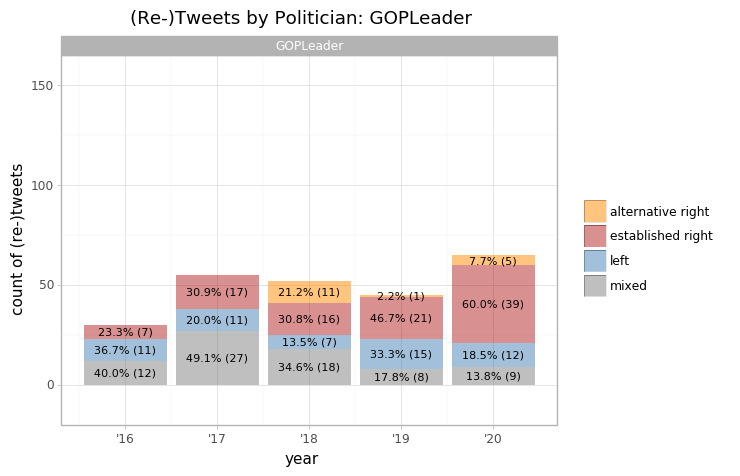

<ggplot: (8787935588925)>

In [14]:
for name in selected_usernames:
    display(plot_user(name))

In [15]:
# check: the counts from the dataframe match the plot above
df_urls.query('username == "GOPLeader"').groupby(['created_at_year', 'ideo_subcategory'])['created_at_year'].value_counts()

created_at_year  ideo_subcategory   created_at_year
2016-01-01       established right  2016-01-01          7
                 left               2016-01-01         11
                 mixed              2016-01-01         12
2017-01-01       established right  2017-01-01         17
                 left               2017-01-01         11
                 mixed              2017-01-01         27
2018-01-01       alternative right  2018-01-01         11
                 established right  2018-01-01         16
                 left               2018-01-01          7
                 mixed              2018-01-01         18
2019-01-01       alternative right  2019-01-01          1
                 established right  2019-01-01         21
                 left               2019-01-01         15
                 mixed              2019-01-01          8
2020-01-01       alternative right  2020-01-01          5
                 established right  2020-01-01         39
                 lef

In [16]:
df_urls.query('username == "GOPLeader"').query('ideo_subcategory == "alternative right"').groupby(['created_at_year', 'outlet']).size()

created_at_year  outlet          
2018-01-01       Breitbart           10
                 Newsmax              1
2019-01-01       One America News     1
2020-01-01       Breitbart            5
dtype: int64

In [17]:
df_urls.query('username == "RepKinzinger"').query('ideo_subcategory == "alternative right"').groupby(['created_at_year', 'outlet']).size()

created_at_year  outlet 
2019-01-01       Newsmax    2
2020-01-01       Newsmax    1
dtype: int64

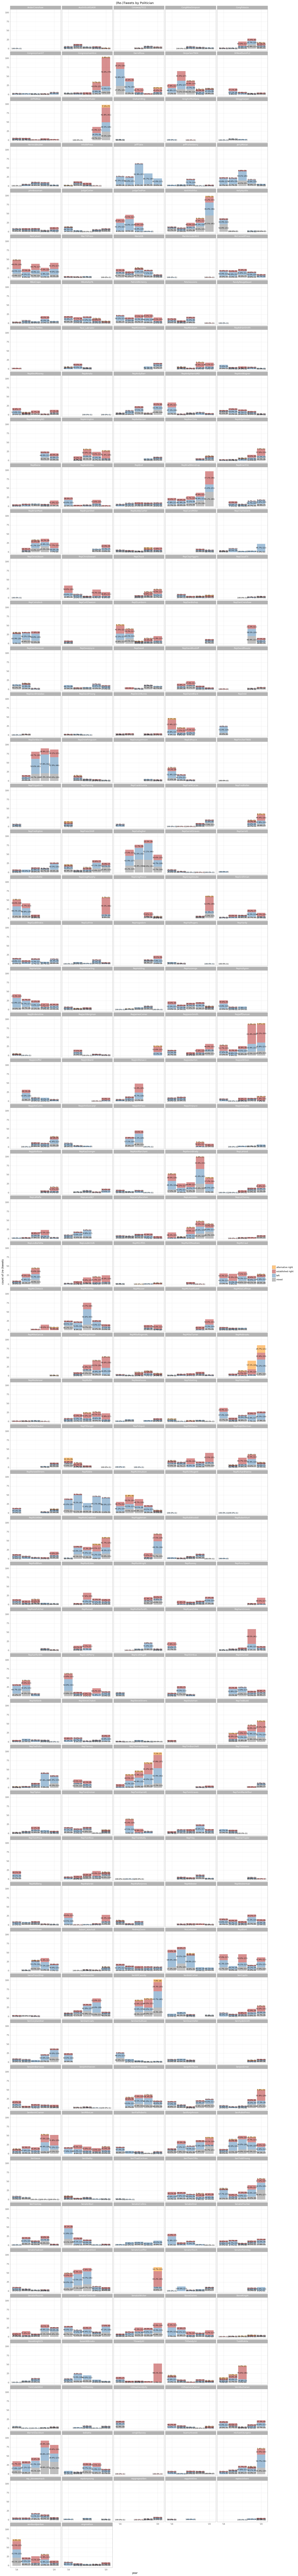

<ggplot: (8787935654217)>

In [18]:
(p9.ggplot(data=df_ps[~df_ps['username'].isin(selected_usernames)] ,
                    mapping=p9.aes(x='created_at_year', y='count_by_year_ideo'))
                 + p9.geom_col(p9.aes(fill='ideo_subcategory'), stat='identity', alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey'])
                 + p9.geom_text(
                     p9.aes(label='label', group='ideo_subcategory'),
                     position = p9.position_stack(vjust = .5),
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.facet_wrap("username", labeller='label_value', ncol=5)
                 + p9.theme_light()
                 + p9.theme(figure_size=(20, 200))
                 + p9.labs(title="(Re-)Tweets by Politician",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )